In [146]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
import numpy as np
import utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

torch.manual_seed(42069)
# if gpu available else cpu
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
TRAIN_MEAN = [0.5036, 0.4719, 0.3897]
TRAIN_STD = [0.2623, 0.2577, 0.2671]
classes = ['butterfly','cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']

In [147]:
df = pd.read_csv('models/results.csv')
session_ordered = [
    '20221209_230012', '20221209_213015', '20221209_215731', '20221209_211433', '20221209_195344', '20221222_085837'
]
session_map = {
    '20221209_230012': 'LeNet - Random Weights',
    '20221209_213015': 'AlexNet - Random Weights', 
    '20221209_215731': 'AlexNet - ImgNet Weights', 
    '20221209_211433': 'ResNet - Random Weights', 
    '20221209_195344': 'ResNet - ImgNet Weights', 
    '20221222_085837': 'ResNet - Long training '
}

## Metryki modeli

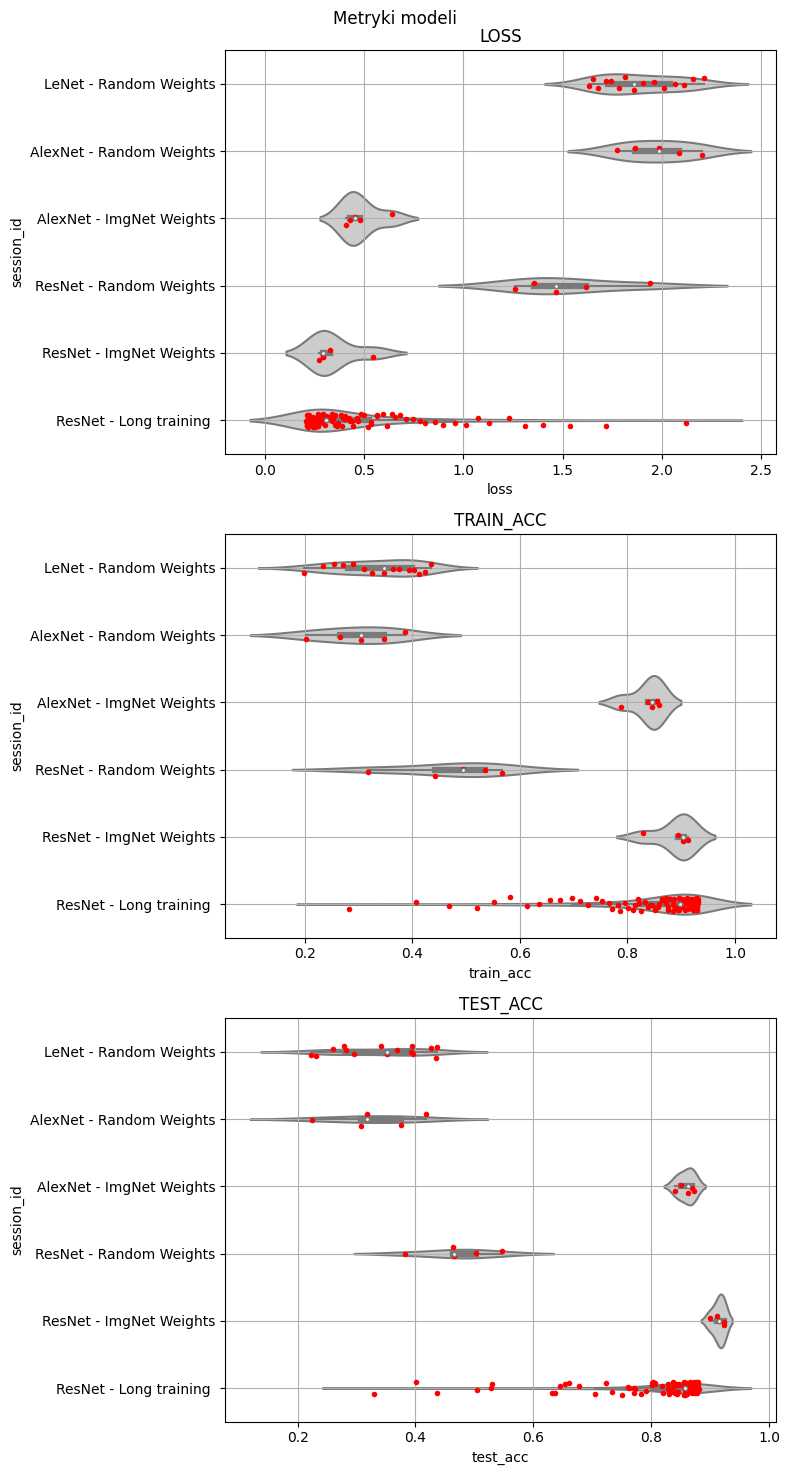

In [148]:
x = df.copy()
# sortowanie po session id
x.session_id = x.session_id.astype('category').cat.set_categories(session_ordered)
x = x.sort_values(['session_id'])
# przypisanie nazw sesjom
x.session_id = x.session_id.map(session_map)

fig, ax = plt.subplots(3, 1, figsize=(8, 15), tight_layout=True)
fig.suptitle('Metryki modeli')
for i, metric in enumerate(['loss', 'train_acc', 'test_acc']):
    sns.stripplot(data=x, x=metric, y="session_id", size=4, color='red', ax=ax[i])
    sns.violinplot(data=x, x=metric, y="session_id", color=".8", ax=ax[i])
    ax[i].set_title(metric.upper())
    ax[i].grid(True)

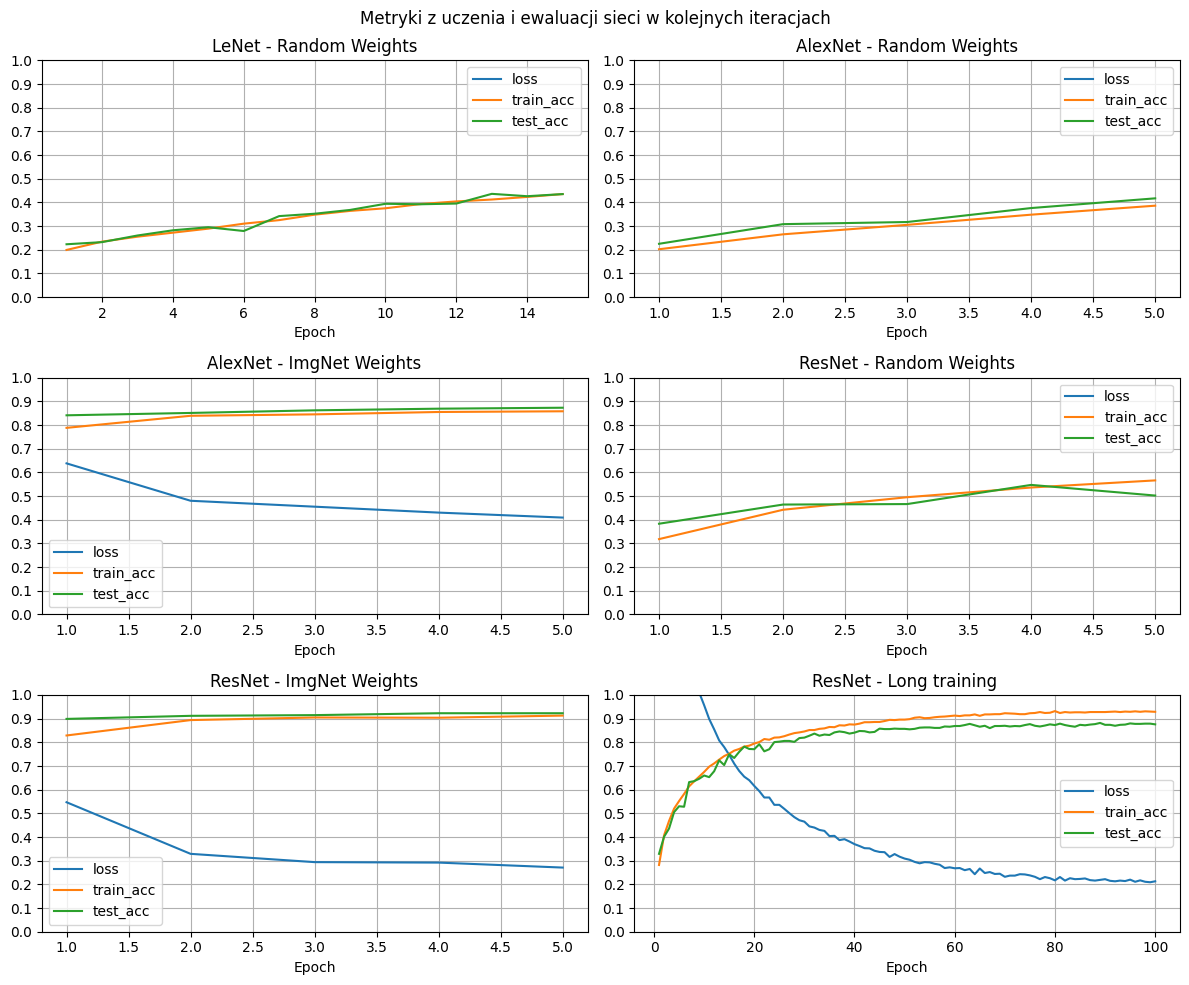

In [149]:
fig, ax = plt.subplots(3, 2, figsize=(12,10))

for i in range(3):
    for j in range(2):
        session = session_ordered[2*i+j]
        ax[i, j].plot(df[df.session_id == session].epoch, df[df.session_id == session].loss)
        ax[i, j].plot(df[df.session_id == session].epoch, df[df.session_id == session].train_acc)
        ax[i, j].plot(df[df.session_id == session].epoch, df[df.session_id == session].test_acc)
        ax[i, j].set_ylim([0, 1])
        ax[i, j].set_yticks(np.linspace(0,1,11))
        ax[i, j].set_title(session_map[session])
        ax[i, j].legend(['loss', 'train_acc', 'test_acc'])
        ax[i, j].set_xlabel('Epoch')
        ax[i, j].grid(True)
#fig.suptitle('Saved metrics')
fig.suptitle("Metryki z uczenia i ewaluacji sieci w kolejnych iteracjach")
fig.tight_layout()

## Wczytanie wytrenowanego modelu

In [150]:
res_net_model = resnet18()
res_net_model.fc = nn.Linear(res_net_model.fc.in_features, len(classes))

def model_train_evaluation(model_params_file, model):
    # zaladowanie modelu i wczytanie na gpu
    model.load_state_dict(torch.load(model_params_file))
    model.to(device)
    
    # zdefiniowanie operacji na kazdym obrazie w zbiorze
    transform = transforms.Compose([
        transforms.RandomResizedCrop(256),  
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),              
        transforms.Normalize(TRAIN_MEAN, TRAIN_STD) 
    ])
    # loader danych z batchami
    test_data = ImageFolder(root='dataset/test/', transform=transform)
    batch_size = 32
    test_loader = DataLoader(test_data, batch_size=batch_size)

    ## PREDYKCJA OGÓŁEM BEZ PODZIAŁU NA KLASY
    correct = 0
    total = 0
    ## PREDYKCJA Z PODZIAŁEM NA KLASY    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    ## WSZYSTKIE PREDYKCJE I LABELE DO CONFUSION MATRIX
    all_predictions = torch.tensor([], device=device)
    all_labels = torch.tensor([], device=device)
    
    with torch.no_grad():
        model.eval()
        for images, labels in test_loader:
            # PREDYKCJA
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, 1)
            # SPRAWDZENIE ILE POPRAWNIE
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # SPRAWDZANIE DLA POSZCZEGOLNYCH KLAS
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1      
            # SKLEJANIE WSZYSTKICH PREDYKCJI I LABELI
            all_predictions = torch.concat([all_predictions, predicted], dim=0)        
            all_labels = torch.concat([all_labels, labels], dim=0)

    print(f'Dokładność dla wszystkich klas: {100 * correct // total:.2f} %')

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Dokładność dla klasy: {classname} is {accuracy:.2f} %')

    cm = confusion_matrix(all_labels.cpu().numpy(),all_predictions.cpu().numpy())
    return cm

In [151]:
cm = model_train_evaluation('model_params/20221222_085837', res_net_model)
cm

Dokładnośc sieci na wszystkich obrazach: 87.00 %
Dokładnośc dla klasy: butterfly is 88.26 %
Dokładnośc dla klasy: cat is 84.89 %
Dokładnośc dla klasy: chicken is 88.90 %
Dokładnośc dla klasy: cow is 76.87 %
Dokładnośc dla klasy: dog is 88.82 %
Dokładnośc dla klasy: elephant is 86.46 %
Dokładnośc dla klasy: horse is 88.57 %
Dokładnośc dla klasy: sheep is 83.08 %
Dokładnośc dla klasy: spider is 93.62 %
Dokładnośc dla klasy: squirrel is 83.48 %


array([[ 466,    6,    5,    3,    8,    1,    3,    1,   30,    5],
       [   1,  354,    4,    2,   42,    4,    1,    2,    2,    5],
       [   8,    8,  689,    5,   28,    3,    7,    4,   16,    7],
       [   0,    2,    9,  359,   37,    7,   33,   15,    4,    1],
       [   8,   28,   11,   11, 1080,    8,   32,   10,   17,   11],
       [   2,    3,    2,    5,   15,  313,    9,    6,    5,    2],
       [   4,    3,    4,   20,   27,    5,  581,    5,    4,    3],
       [   0,    4,    9,   14,   16,    9,   13,  378,    2,   10],
       [  27,    6,    5,    2,   10,    1,    2,    5, 1129,   19],
       [   6,   12,   14,    0,   20,    5,    1,    1,   18,  389]],
      dtype=int64)

## Wnioski:
- Wytrenowanie własnego modelu do zadań klasyfikacji obrazu jest czasochłonne. Trenowanie sieci przez 100 epok zajeło prawie 5 godzin, a ostateczny model na zbiorze testowym osiąga o 7 punktów procentowych niższa dokładność niż dotrenowany model z wagami zbioru ImageNet. 